In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from datetime import datetime as dt
from pandas_datareader import DataReader as DR
import seaborn as sb
import numdifftools as nd
from wquantiles import quantile

from scipy.stats import multivariate_normal as multi_norm
from scipy.stats import multivariate_t as multi_t
from scipy.stats import norm,t,truncnorm
from scipy.spatial import Delaunay as TRI
from scipy.interpolate import LinearNDInterpolator as ITP
from scipy.optimize import minimize

from sklearn.linear_model import LinearRegression as Linear
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.neighbors import KernelDensity as KDE

import warnings
warnings.filterwarnings("ignore")

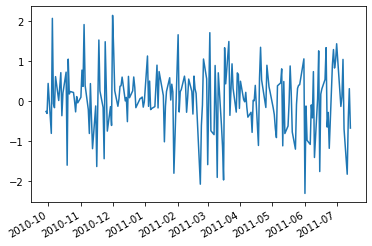

In [2]:
data=DR('^GSPC','yahoo',dt(2010,9,29),dt(2011,7,14))
returns=pd.DataFrame(100*np.diff(np.log(data['Adj Close'])),columns=['dlr'])
returns.index=data.index.values[1:data.index.values.shape[0]]

returns['dlr'].plot()
plt.show()
returns=np.array(returns['dlr'])

h0=np.std(returns)
y0=returns[0]
YT=returns[1:]
T=YT.size
prior_pars=[-1,2]
truth=np.array([[-1.333,-1.895],[-1.886,-2.771],[-2.996,-4.424]])

In [3]:
def posterior_prediction(pars,pre=False):
    good=(np.exp(pars[:,0])<=1e300)
    good&=(pars[:,1]>0)*(pars[:,2]>0)*(pars[:,1]+pars[:,2]<1)
    neglogpdfpT=0.5*((pars[:,0]-prior_pars[0])/prior_pars[1])**2
    neglogpdfpT[~good]=np.inf
    HTd=np.ones(pars.shape[0])
    HTd[good]=np.exp(pars[good,0])+pars[good,1]*y0**2+pars[good,2]*h0
    for i in range(T):
        neglogpdfpT+=0.5*(YT[i]**2/HTd+np.log(HTd))
        HTd[good]=np.exp(pars[good,0])+pars[good,1]*YT[i]**2+pars[good,2]*HTd[good]
        
    if pre:
        Yd=np.zeros([pars.shape[0],d])
        pdfpdpt=np.zeros(pars.shape[0])
        good=(np.exp(-neglogpdfpT)!=0)
        pdfpdpt[good]=1
        if d>1:
            for i in range(d-1):
                Yd[good,i]=norm.rvs(scale=np.sqrt(HTd[good]))
                pdfpdpt[good]*=norm.pdf(x=Yd[good,i],scale=np.sqrt(HTd[good]))
                HTd[good]=np.exp(pars[good,0])+pars[good,1]*Yd[good,i]**2+pars[good,2]*HTd[good]
            
        return neglogpdfpT,HTd,Yd,pdfpdpt
    else:
        return neglogpdfpT

def MLE():
    cons=({'type':'ineq',\
           'fun':lambda pars: np.array([pars[1],pars[2],1-pars[1]+pars[2]]),\
           'jac':lambda x: np.array([[0,1,0],[0,0,1],[0,-1,-1]])})
    target=lambda pars: posterior_prediction(pars.reshape([1,3]))
    res=minimize(target,[0,0.1,0.7],method='SLSQP',constraints=cons,\
                 options={'maxiter':1000,'ftol':1e-100,'disp':False})
    mu=res['x']
    Sigma=np.linalg.inv(nd.Hessian(target)(mu))
    Sigma[:,0]*=2
    Sigma[0,:]*=2
    return mu,Sigma

def estimation(RYd,W,p,ESS=False):
    VaR=quantile(RYd,W,p)
    w=W/np.sum(W)
    avar=np.sum((w*((RYd<=VaR)-p))**2)*RYd.size
    if ESS:
        print('ESS for',str(p)+':')
        Wf=W*(RYd<=VaR)
        wf=Wf/np.sum(Wf)
        ne=1/np.sum(w**2)
        nef=1/np.sum(wf**2)
        print('ne:',ne,'nef:',nef)
        W2=W**2
        w2=W2/np.sum(W2)
        Wf2=(W*((RYd<=VaR)-p))**2
        wf2=Wf2/np.sum(Wf2)
        ne2=1/np.sum(w2**2)
        nef2=1/np.sum(wf2**2)
        print('ne2:',ne2,'nef2:',nef2)
        
    return VaR,avar

def MLE_estimation(RYd,pdfp,pdfqs):
    pdfg=pdfqs[1:]-pdfqs[0]
    pdfq=pdfqs.mean(axis=0)
    target=lambda zeta: -np.sum(np.log(pdfq+zeta.reshape([1,-1]).dot(pdfg).flatten()))
    gradient=lambda zeta: -np.sum(pdfg/(pdfq+zeta.reshape([1,-1]).dot(pdfg).flatten()),axis=1)
    zeta0=np.zeros(pdfg.shape[0])
    cons=({'type':'ineq',\
           'fun':lambda zeta: pdfq+zeta.reshape([1,-1]).dot(pdfg).flatten(),\
           'jac':lambda zeta: pdfg.T})
    res=minimize(target,zeta0,method='SLSQP',jac=gradient,constraints=cons,\
                 options={'maxiter':1000,'ftol':1e-100,'disp':False})
    if res['success']:
        zeta=res['x']
        print('MLE nit:',res['nit'])
        tmp=np.append(-zeta.sum(),zeta)
        print('MLE alpha:',np.ones(pdfqs.shape[0])/pdfqs.shape[0]+tmp)
        W=pdfp/(pdfq+zeta.reshape([1,-1]).dot(pdfg).flatten())
        print('MLE VaR0.05:',estimation(RYd,W,0.05,False)[0])
        print('MLE VaR0.01:',estimation(RYd,W,0.01,False)[0])
    else:
        print('MLE fail')

def pilot(n,K):
    pars=np.array([t.rvs(size=2*n,df=1,loc=mu[i],scale=np.sqrt(Sigma[i,i])) for i in range(3)]).T
    pdft=np.prod([t.pdf(x=pars[:,i],df=1,loc=mu[i],scale=np.sqrt(Sigma[i,i])) for i in range(3)],axis=0)
    neglogpdfpT,HTd,Yd=posterior_prediction(pars,True)[:3]
    pdfpT=np.exp(-neglogpdfpT)
    good=(pdfpT!=0)
    print('Samples in feasible region:',np.mean(good))
    
    YTd1gd=norm.rvs(scale=np.sqrt(HTd[good&(np.arange(2*n)<n)]))
    YTd2gd=norm.rvs(loc=-np.sqrt(HTd[good&(np.arange(2*n)>=n)]),scale=np.sqrt(HTd[good&(np.arange(2*n)>=n)]))
    Yd[good,d-1]=np.hstack([YTd1gd,YTd2gd])
    RYd=Yd.sum(axis=1)
    
    pdfp=np.zeros(2*n)
    pdfqs=np.ones([2,2*n])
    pdfpTdgd=norm.pdf(x=Yd[good,d-1],scale=np.sqrt(HTd[good]))
    pdfp[good]=pdfpT[good]*pdfpTdgd
    pdfqs[0,good]=pdft[good]*pdfpTdgd
    pdfqs[1,good]=pdft[good]*norm.pdf(x=Yd[good,d-1],loc=-np.sqrt(HTd[good]),scale=np.sqrt(HTd[good]))
    
    W=pdfp/pdfqs.mean(axis=0)
    VaR1,avar1=estimation(RYd,W,0.05)
    VaR2,avar2=estimation(RYd,W,0.01)
    print('VaR0.05:',VaR1,'avar:',avar1)
    print('VaR0.01:',VaR2,'avar:',avar2)
    MLE_estimation(RYd,pdfp,pdfqs)
    
    index=np.arange(2*n)
    W1=W*np.abs((RYd<VaR1)-0.05)
    W2=W*np.abs((RYd<VaR2)-0.01)
    ind1=np.random.choice(index,K,p=W1/np.sum(W1))
    ind2=np.random.choice(index,K,p=W2/np.sum(W2))
    return pars,Yd,ind1,ind2,good

mu: [-2.33361691  0.05730325  0.78963931]
Reference for d = 2: VaR0.05: -1.886 VaR0.01: -2.771
Samples in feasible region: 0.424785
VaR0.05: -1.855396756317993 avar: 3.4016787455804347
VaR0.01: -2.864425190835138 avar: 1.0589841323538245
MLE nit: 4
MLE alpha: [0.50361672 0.49638328]
MLE VaR0.05: -1.8554613048039783
MLE VaR0.01: -2.8644682570556648


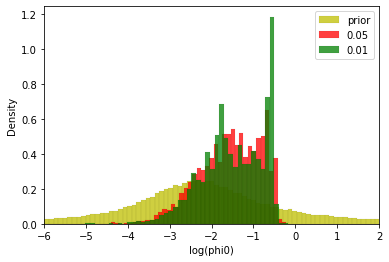

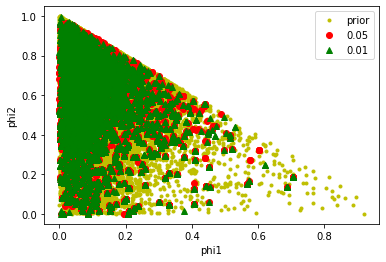

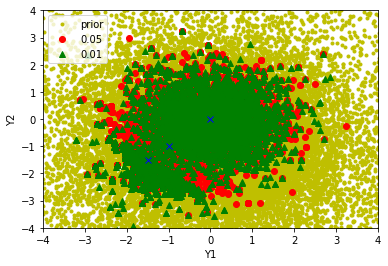

In [24]:
d=2
n=100000
K=10000
mu,Sigma=MLE()
print('mu:',mu)
np.random.seed(3033079628)
print('Reference for d = '+str(d)+':','VaR0.05:',truth[1,0],'VaR0.01:',truth[1,1])
pars,Yd,ind1,ind2,good=pilot(n,K)
pars1=pars[ind1]
pars2=pars[ind2]
Yd1=Yd[ind1]
Yd2=Yd[ind2]

sb.histplot(pars[good,0],color='y',label='prior',stat='density')
sb.histplot(pars1[:,0],color='r',label=0.05,stat='density')
sb.histplot(pars2[:,0],color='g',label=0.01,stat='density')
plt.xlabel('log(phi0)')
plt.xlim([-6,2])
plt.legend()
plt.show()

plt.plot(pars[good,1],pars[good,2],'.y',label='prior')
plt.plot(pars1[:,1],pars1[:,2],'or',label=0.05)
plt.plot(pars2[:,1],pars2[:,2],'^g',label=0.01)
plt.xlabel('phi1')
plt.ylabel('phi2')
plt.legend()
plt.show()

plt.plot(Yd[good,0],Yd[good,1],'.y',label='prior')
plt.plot(Yd1[:,0],Yd1[:,1],'or',label=0.05)
plt.plot(Yd2[:,0],Yd2[:,1],'^g',label=0.01)
plt.plot([0,-1.5,-1],[0,-1.5,-1],'xb')
plt.xlabel('Y1')
plt.ylabel('Y2')
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.legend()
plt.show()

mu: [-2.33361691  0.05730325  0.78963931]
Reference for d = 1: VaR0.05: -1.333 VaR0.01: -1.895
Samples in feasible region: 0.424785
VaR0.05: -1.3060566971494738 avar: 1.7056556182910245
VaR0.01: -1.8686800666139403 avar: 0.16194995083738667
MLE nit: 4
MLE alpha: [0.49429644 0.50570356]
MLE VaR0.05: -1.3058797011924639
MLE VaR0.01: -1.8649600034125173


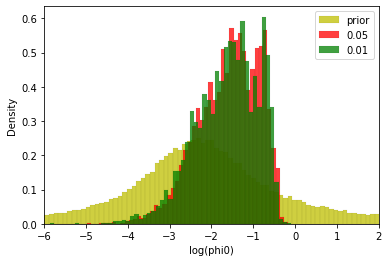

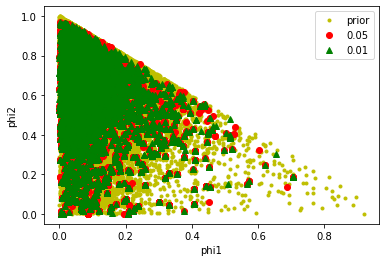

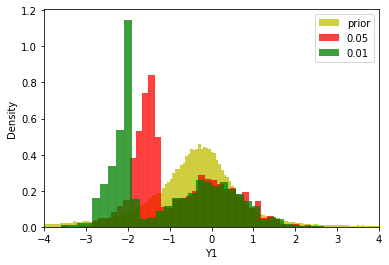

In [7]:
d=1
n=100000
K=10000
mu,Sigma=MLE()
print('mu:',mu)
np.random.seed(3033079628)
print('Reference for d = '+str(d)+':','VaR0.05:',truth[0,0],'VaR0.01:',truth[0,1])
pars,Yd,ind1,ind2,good=pilot(n,K)
pars1=pars[ind1]
pars2=pars[ind2]
Yd1=Yd[ind1]
Yd2=Yd[ind2]

sb.histplot(pars[good,0],color='y',label='prior',stat='density')
sb.histplot(pars1[:,0],color='r',label=0.05,stat='density')
sb.histplot(pars2[:,0],color='g',label=0.01,stat='density')
plt.xlabel('log(phi0)')
plt.xlim([-6,2])
plt.legend()
plt.show()

plt.plot(pars[good,1],pars[good,2],'.y',label='prior')
plt.plot(pars1[:,1],pars1[:,2],'or',label=0.05)
plt.plot(pars2[:,1],pars2[:,2],'^g',label=0.01)
plt.xlabel('phi1')
plt.ylabel('phi2')
plt.legend()
plt.show()

sb.histplot(Yd[good,0],color='y',label='prior',stat='density')
sb.histplot(Yd1[:,0],color='r',label=0.05,stat='density')
sb.histplot(Yd2[:,0],color='g',label=0.01,stat='density')
plt.xlabel('Y1')
plt.xlim([-4,4])
plt.legend()
plt.show()

In [28]:
print(np.corrcoef(np.hstack([pars[ind1],Yd[ind1]]).T))
print(np.corrcoef(np.hstack([pars[ind2],Yd[ind2]]).T))
print(np.cov(Yd[good].T))

[[ 1.         -0.00687433 -0.91605165  0.01880592  0.01245184]
 [-0.00687433  1.         -0.12686637  0.03532883  0.02797409]
 [-0.91605165 -0.12686637  1.         -0.00412953 -0.01063759]
 [ 0.01880592  0.03532883 -0.00412953  1.          0.30561102]
 [ 0.01245184  0.02797409 -0.01063759  0.30561102  1.        ]]
[[ 1.         -0.1563623  -0.92059787 -0.09108122  0.03034091]
 [-0.1563623   1.          0.08655931  0.11346963 -0.03076763]
 [-0.92059787  0.08655931  1.          0.12562524 -0.02248898]
 [-0.09108122  0.11346963  0.12562524  1.          0.50443088]
 [ 0.03034091 -0.03076763 -0.02248898  0.50443088  1.        ]]
[[17.29410024  0.53026633]
 [ 0.53026633 28.35234381]]
